### Задача тематическое моделирование

продолжаем исследование датасета с твитами

Скачиваем датасет ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

или можно через ноутбук

!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

как альтернатива можно скачать данные из Роспотребнадзора 
https://zpp.rospotrebnadzor.ru/Forum/Appeals
для этого берём ноутбук `parse_rospotrebnadzor.ipynb`
устанавливаем количество скачанных страниц больше не 50-сят хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда

что надо сделать 
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики

Будем работать с твитами

Подгружаем необходимые библиотеки

In [62]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import re
import string
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from multiprocessing import Pool

from pymystem3 import Mystem

from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words

import nltk
from nltk.tokenize import word_tokenize

from gensim.models import *
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

In [63]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [64]:
positive = pd.read_csv('../Less_2/positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('../Less_2/negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)

In [65]:
df = pd.concat([positive, negative], ignore_index=True)
df.head()

,text,label
0,"@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)",positive
1,"Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D",positive
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за тебя!!!,positive
3,"RT @digger2912: ""Кто то в углу сидит и погибает от голода, а мы ещё 2 порции взяли, хотя уже и так жрать не хотим"" :DD http://t.co/GqG6iuE2…",positive
4,"@irina_dyshkant Вот что значит страшилка :D\nНо блин,посмотрев все части,у тебя создастся ощущение,что авторы курили что-то :D",positive


In [66]:
# Препроцессинг текста

stopwords = set(get_stop_words("ru") + ['свой', 'столько', 'либо', 'здравствуйте', 'добрый', 'день'])
morpher = MorphAnalyzer()

def preprocess_txt(text):
    text = text.lower() # Нижний регистр
    text = re.sub(r'@\w+', '', text) # Remove @username
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(" \d+", " ", text) # Числа
    text = re.sub(r'[:;=]-?[()DPd]', '', text) # Remove смайликов
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation

    ignore_list = [r'\w+ще\b',r'который',r'\bидио\w+',r'почему',
                   r'\bпид\w+',r'весь',r'значит',r'\bхуй\w+',r'\bхуй\w+',r'\w+xу.\b',
                   r'\bбл\w+',r'\w+xу\w+',r'\w+но\b',r'очень',r'\bпиз\w+',r'это',
                   r'\bгов\w+',r'\bпи.де\w+',r'лох',r'нету',r'ой',r'мочь',r'\w+ть\b',
                   r'\bфиг\w+',r'сука',r'\bпоп\w+',r'свой',r'капец']
    for i in ignore_list:
      text = re.sub(i, '',  text)

    words = word_tokenize(text) # Токенизация
    words = [morpher.parse(word)[0].normal_form for word in words] # Лемматизация
    words = [word for word in words if len(word)>2] # Слова длинной больше 2 символов
    words = [word for word in words if word not in stopwords] # Стоп слова

   
    return words

<>:10: DeprecationWarning: invalid escape sequence \d
<>:10: DeprecationWarning: invalid escape sequence \d
/var/folders/j2/7fhv7lr576j7qyw_1c_4v7rr0000gn/T/ipykernel_63978/3557044136.py:10: DeprecationWarning: invalid escape sequence \d
  text = re.sub(" \d+", " ", text) # Числа
/Users/aleksandrkrylov/anaconda3/lib/python3.9/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/Users/aleksandrkrylov/anaconda3/lib/python3.9/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/Users/aleksandrkrylov/anaconda3/lib/python3.9/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, u

In [67]:
df.text.iloc[1]

'Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D'

In [68]:
print(preprocess_txt(df.text.iloc[1]))

['таки', 'похожий', 'мальчик', 'хороший']


In [69]:
df['text']= df['text'].apply(preprocess_txt)

In [70]:
df['text'].head()

0    [школотый, поверь, самый, общество, профилировать, предмет, тип]
1                                   [таки, похожий, мальчик, хороший]
2                                                        [испугаться]
3                      [угол, сидеть, погибать, голод, порция, взять]
4         [страшилка, частиу, создаться, ощущениечтый, автор, курить]
Name: text, dtype: object

## Модель LDA

Модель использует векторное представление документов, поэтому еизначально нужно словарь

In [71]:
dictionary = corpora.Dictionary(df['text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 

dictionary.save('tweets_dict.dict')

Векторизуем документы

In [72]:
corpus = [dictionary.doc2bow(text) for text in df['text']]

corpora.MmCorpus.serialize('tweets_corpus.model', corpus)

In [73]:
# Обучение модели

lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=5, chunksize=100, update_every=1, passes=5)

In [74]:
lda.show_topics(num_topics=5, num_words=7, formatted=True)

[(0,
  '0.026*"хороший" + 0.020*"болеть" + 0.019*"жаль" + 0.018*"утро" + 0.014*"любимый" + 0.013*"делать" + 0.009*"смочь"'),
 (1,
  '0.036*"завтра" + 0.031*"знать" + 0.028*"дом" + 0.023*"идти" + 0.021*"школа" + 0.015*"никто" + 0.014*"мама"'),
 (2,
  '0.027*"любить" + 0.023*"самый" + 0.022*"час" + 0.017*"ночь" + 0.016*"стать" + 0.016*"понимать" + 0.015*"новый"'),
 (3,
  '0.020*"хотеться" + 0.019*"думать" + 0.017*"писать" + 0.015*"неделя" + 0.013*"нибыть" + 0.013*"дело" + 0.011*"нравиться"'),
 (4,
  '0.027*"большой" + 0.020*"скучать" + 0.018*"друг" + 0.016*"сидеть" + 0.015*"работа" + 0.013*"скоро" + 0.011*"фильм"')]

In [75]:
vis_data = gensimvis.prepare(lda, corpus, dictionary, mds='tsne')
pyLDAvis.display(vis_data)

/Users/aleksandrkrylov/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Посмотрим на метрики качества получившейся модели: перплексию и среднюю когерентность

In [76]:
print(lda.log_perplexity(corpus))
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

-8.871598546580712
Персплексия:  0.00014031748215946436


In [77]:
coherence_model_lda = CoherenceModel(model=lda, texts=['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  nan


/Users/aleksandrkrylov/anaconda3/lib/python3.9/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
/Users/aleksandrkrylov/anaconda3/lib/python3.9/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


Подоберем оптимальное количество тем, опираясь на значение метрик:

  0%|          | 0/7 [00:00<?, ?it/s]

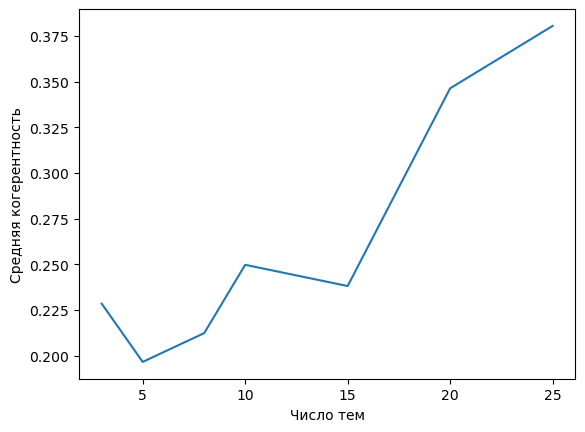

In [78]:
topics_list = [3, 5, 8, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=df['text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [79]:
lda_10 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, chunksize=100, update_every=1, passes=5)

lda_10.show_topics(num_topics=10, num_words=7, formatted=True)

[(0,
  '0.034*"стать" + 0.026*"прийти" + 0.025*"фильм" + 0.025*"минута" + 0.024*"забыть" + 0.018*"конец" + 0.017*"таки"'),
 (1,
  '0.048*"никто" + 0.026*"ждать" + 0.023*"казаться" + 0.022*"город" + 0.021*"слово" + 0.019*"давать" + 0.019*"правда"'),
 (2,
  '0.043*"жаль" + 0.042*"писать" + 0.030*"дело" + 0.027*"найти" + 0.026*"нравиться" + 0.024*"бояться" + 0.023*"прийтись"'),
 (3,
  '0.066*"знать" + 0.045*"любить" + 0.038*"самый" + 0.028*"ночь" + 0.024*"новый" + 0.017*"видеть" + 0.016*"вроде"'),
 (4,
  '0.041*"час" + 0.026*"настроение" + 0.026*"нибыть" + 0.025*"вчера" + 0.024*"делать" + 0.019*"жалко" + 0.018*"пойти"'),
 (5,
  '0.050*"думать" + 0.023*"вечер" + 0.022*"заболеть" + 0.022*"получиться" + 0.020*"выйти" + 0.020*"наверное" + 0.018*"никак"'),
 (6,
  '0.067*"завтра" + 0.044*"идти" + 0.039*"школа" + 0.038*"хороший" + 0.031*"скучать" + 0.030*"болеть" + 0.026*"мама"'),
 (7,
  '0.039*"хотеться" + 0.035*"друг" + 0.029*"работа" + 0.026*"любимый" + 0.023*"остаться" + 0.017*"ранний" + 0.0

Интерпретация тем :
0. Обсуждение фильмов
1. Личные встречи в городе
2. Писательская деятельность
3. Ночная жизнь
4. Что делали вчера
5. Семейные отношения
6. Школьная жизнь
7. Баланс жизни и работы
8. Выходные 
9. Домоседы против улицы


In [ ]:
pyLDAvis.save_html(vis_data, 'hw04_visual.html')